# Gradient Boosting with XGBoost

## Dataset Description
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* `Id` - an Id that represents a (Store, Date) duple within the test set
* `Store` - a unique Id for each store
* `Sales` - the turnover for any given day (this is what you are predicting)
* `Customers` - the number of customers on a given day
* `Open` - an indicator for whether the store was open: 0 = closed, 1 = open
* `StateHoliday` - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* `SchoolHoliday` - indicates if the (Store, Date) was affected by the closure of public schools
* `StoreType` - differentiates between 4 different store models: a, b, c, d
* `Assortment` - describes an assortment level: a = basic, b = extra, c = extended
* `CompetitionDistance` - distance in meters to the nearest competitor store
* `CompetitionOpenSince[Month/Year]` - gives the approximate year and month of the time the nearest competitor was opened
* `Promo` - indicates whether a store is running a promo on that day
* `Promo2` - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* `Promo2Since[Year/Week]` - describes the year and calendar week when the store started participating in Promo2
* `PromoInterval` - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Importing Libraries

In [1]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
#import jovian
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## Importing Data

In [2]:
ross_df = pd.read_csv('train.csv', low_memory=False)
store_df = pd.read_csv('store.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
ross_df


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [4]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Let's merge the information from `store_df` into `train_df` and `test_df`.

In [5]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [6]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO


### Date

First, let's convert `Date` to a `datetime` column and extract different parts of the date.

In [8]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.week

In [9]:
split_date(merged_df)
split_date(merged_test_df)

In [10]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


In [11]:
merged_df['Open'].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [12]:
merged_df[merged_df.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [13]:
merged_df = merged_df[merged_df.Open == 1].copy()

In [14]:
merged_df['Open'].value_counts()

1    844392
Name: Open, dtype: int64

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [15]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [16]:
comp_months(merged_df)
comp_months(merged_test_df)

In [17]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [18]:
promo_cols(merged_df)
promo_cols(merged_test_df)

### Input and Target Columns

Let's select the columns that we'll use for training.

In [19]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [20]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [21]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [22]:
test_inputs = merged_test_df[input_cols].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [23]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing numerical data

In [24]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [25]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [26]:
max_distance = inputs.CompetitionDistance.max()

In [27]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [30]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [32]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
inputs = inputs.drop(categorical_cols, axis=1)
test_inputs = test_inputs.drop(categorical_cols, axis=1)

In [34]:
inputs

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,0.000000,1.0,1.0,0.016482,0.059163,1.0,0.545455,1.0,0.588235,0.0,0.000000,0.0
1,0.000898,1.0,1.0,0.007252,0.066378,1.0,0.545455,1.0,0.588235,1.0,0.890710,1.0
2,0.001795,1.0,1.0,0.186050,0.074315,1.0,0.545455,1.0,0.588235,1.0,0.720856,1.0
3,0.002693,1.0,1.0,0.007911,0.050505,1.0,0.545455,1.0,0.588235,0.0,0.000000,0.0
4,0.003591,1.0,1.0,0.394119,0.002165,1.0,0.545455,1.0,0.588235,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.611311,0.0,1.0,0.001714,0.054834,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1016827,0.657092,0.0,1.0,0.011076,0.114719,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1016863,0.689408,0.0,1.0,0.010812,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.016849,1.0
1017042,0.850090,0.0,1.0,0.018592,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [35]:
X = inputs
X_test = test_inputs

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 




For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)


In [36]:
from xgboost import XGBRegressor

In [37]:
?XGBRegressor

In [38]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

Let's train the model using `model.fit`.

In [39]:
%%time
model.fit(X, targets)

Wall time: 3.69 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [40]:
preds = model.predict(X)

In [41]:
preds

array([8121.4604, 8007.219 , 9447.751 , ..., 6920.664 , 6992.154 ,
       6850.191 ], dtype=float32)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [42]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [43]:
rmse(preds, targets)

2499.521391427993

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [44]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

In [53]:
#plot_tree(model, rankdir='LR');
#plot_tree(model, rankdir='LR', num_trees=1);

In [54]:
trees = model.get_booster().get_dump()


In [55]:
len(trees)


20

In [56]:
print(trees[0])


0:[Promo<0.5] yes=1,no=2,missing=1
	1:[Promo2<0.5] yes=3,no=4,missing=3
		3:[Store<0.998653531] yes=7,no=8,missing=7
			7:[CompetitionDistance<0.0249868147] yes=15,no=16,missing=15
				15:leaf=2066.83862
				16:leaf=1766.09143
			8:leaf=5851.271
		4:[WeekOfYear<0.911764741] yes=9,no=10,missing=9
			9:[CompetitionDistance<0.00349419843] yes=17,no=18,missing=17
				17:leaf=1887.32166
				18:leaf=1591.44275
			10:[SchoolHoliday<0.5] yes=19,no=20,missing=19
				19:leaf=1951.85913
				20:leaf=2449.06519
	2:[Month<0.954545498] yes=5,no=6,missing=5
		5:[CompetitionDistance<0.00309862872] yes=11,no=12,missing=11
			11:[CompetitionDistance<0.000197784801] yes=21,no=22,missing=21
				21:leaf=1979.38171
				22:leaf=2826.21606
			12:[Promo2<0.5] yes=23,no=24,missing=23
				23:leaf=2510.11182
				24:leaf=2255.81909
		6:[Day<0.316666663] yes=13,no=14,missing=13
			13:[Day<0.0500000045] yes=25,no=26,missing=25
				25:leaf=3224.22046
				26:leaf=2743.92334
			14:[Day<0.516666651] yes=27,no=28,missing=

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [57]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [58]:
importance_df.head(10)

,feature,importance
1,Promo,0.477482
2,SchoolHoliday,0.096620
9,Promo2,0.094027
0,Store,0.060700
6,Month,0.053227
3,CompetitionDistance,0.046486
5,Day,0.042362
8,WeekOfYear,0.041657
4,CompetitionOpen,0.035225
10,Promo2Open,0.022315


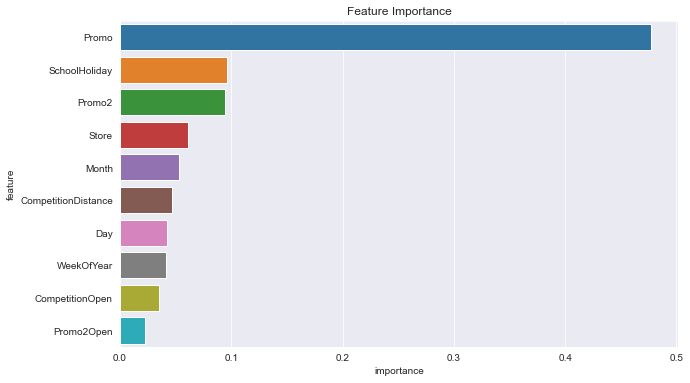

In [59]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

Scikit-learn provides utilities for performing K fold cross validation.

In [60]:
from sklearn.model_selection import KFold

Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [61]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [63]:
kfold = KFold(n_splits=5)

In [65]:
kfold.split(X)

<generator object _BaseKFold.split at 0x000001C8C3E43190>

In [67]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    #print(train_idxs, val_idxs)
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2433.4553785597527, Validation RMSE: 2512.4078511787025
Train RMSE: 2453.617959338975, Validation RMSE: 2507.5012638200346
Train RMSE: 2467.558986117392, Validation RMSE: 2445.8879266922017
Train RMSE: 2432.3017361745206, Validation RMSE: 2529.92924544942
Train RMSE: 2477.218306300191, Validation RMSE: 2509.5363016573015


Let's also define a function to average predictions from the 5 different models.

In [68]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [69]:
preds = predict_avg(models, X)

In [70]:
preds

array([7963.4062, 7820.712 , 9582.557 , ..., 5900.4346, 6926.3657,
       6980.37  ], dtype=float32)

We can now use `predict_avg` to make predictions for the test set.

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [71]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [72]:
?XGBRegressor


Here's a helper function to test hyperparameters with K-fold cross validation.

In [73]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [76]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

## `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.

In [77]:
test_params(n_estimators=10)

Train RMSE: 2475.8652036392355, Validation RMSE: 2478.878431650727


In [78]:
test_params(n_estimators=30)

Train RMSE: 1962.7557115930078, Validation RMSE: 1966.2946707839667


In [79]:
test_params(n_estimators=100)

Train RMSE: 1363.8438499077645, Validation RMSE: 1370.1836065776597


In [80]:
test_params(n_estimators=240)

Train RMSE: 1077.7184917452034, Validation RMSE: 1096.5737081976413


In [81]:
test_params(n_estimators=300)

Train RMSE: 1034.47000464801, Validation RMSE: 1057.4943569699647


## `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [82]:
test_params(max_depth=2)

Train RMSE: 2458.30920995432, Validation RMSE: 2455.644926656357


In [83]:
test_params(max_depth=5)

Train RMSE: 1542.2733581118093, Validation RMSE: 1543.0909731360734


In [84]:
test_params(max_depth=10)

Train RMSE: 886.60035323402, Validation RMSE: 985.7017708938139


In [85]:
test_params(max_depth=15)

Train RMSE: 510.87494599725665, Validation RMSE: 956.3349452182728


In [87]:
test_params(max_depth=20)

Train RMSE: 155.72334293267403, Validation RMSE: 1049.5716797662035


## `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [88]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 5075.385782056938, Validation RMSE: 5076.462587904562


In [89]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 1704.4802609704223, Validation RMSE: 1706.561634232411


In [90]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 1262.1695472394847, Validation RMSE: 1268.9151684425442


In [91]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 1254.2284401980971, Validation RMSE: 1268.5261338217197


## `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [92]:
test_params(booster='gblinear')

Train RMSE: 2836.8385823951007, Validation RMSE: 2845.00440954261


Clearly, a linear model is not well suited for this dataset.

In [ ]:
# gamma, min_child_weight, max_delta_step, subsample, colsample_bytree experiment

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [93]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=300, 
                     learning_rate=0.2, max_depth=15, subsample=0.9, 
                     colsample_bytree=0.7)

In [94]:
%%time
model.fit(X, targets)

Wall time: 2min 29s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [95]:
test_preds = model.predict(X_test)

In [96]:
submission_df['Sales']  = test_preds

Recall, however, if if the store is not open, then the sales must be 0. Thus, wherever the value of `Open` in the test set is 0, we can set the sales to 0. Also, there some missing values for `Open` in the test set. We'll replace them with 1 (open).

In [97]:
test_df.Open.isna().sum()

11

In [98]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [99]:
submission_df

,Id,Sales
0,1,4311.354980
1,2,8296.593750
2,3,7197.625488
3,4,6702.817871
4,5,8931.383789
...,...,...
41083,41084,3810.572266
41084,41085,9216.713867
41085,41086,6128.603027
41086,41087,25709.853516


We can now save the predictions as a CSV file.

In [100]:
submission_df.to_csv('submission.csv', index=None)

In [101]:
from IPython.display import FileLink

In [103]:
FileLink('submission.csv')

C:\Users\alanj\Desktop\Kaggle\Jovian\submission.csv